# Bayesian statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from scipy.stats import hypergeom
from scipy import interpolate

# external libraries
import sys
from importlib import reload
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

**Bayesian statistics with an astro example**

Likehoods do not need to sum of to one, but priors do

In [2]:
lh1 = 0.8     # likelihood of theta 1 (radio loud) 
lh2 = 0.3     # likelihood of theta 2 (radio quiet)
prior1 = 0.1  # prior of theta 1
prior2 = 0.9  # prior of theta 2

# what is the probability of theta 1 given the measurement saying it is theta 1
prob = lh1 * prior1 / (lh1*prior1 + lh2*prior2)
prob

0.2285714285714286

In [3]:
# increasing the false positives by a factor of 2
prob = lh1 * prior1 / (lh1*prior1 + 1/2*lh2*prior2)
prob

0.372093023255814

In [4]:
# incresing prior 1 with 60% - remember to decrease prior 2! they have to sum to one
prob = lh1 * 1.6*prior1 / (lh1*1.6*prior1 + lh2*(1-1.6*prior1))
prob

0.336842105263158

### Exercise 1 - sampling w/o replacement

**Setting up the problem**

We need to estimate the most likely number of fish in the lake ($N$), given the following information:

* we know that $K$ fish in the lake are of a specific kind (tagged);
* we take $n$ fish from the lake and find that $k$ are tagged. 

The question is, how many fish are there in total? Obviously, $N \geq K$ and $N \geq n$, but we would like to know better, and to build a probability distribution of the $N$ values given the information we collected and any prior knowledge on $N$.

We start by defining the $K$, $n$, $k$ and the range of $N$ values:

In [5]:
K = 100  # number of identified fish
n = 60   # number of fish being extracted 
k_val = [10, 15]   # number of fish that have been previously tagged
Nrange = np.arange(100,2500,1)   # range of total number 

**Defining the priors, the likelihood, and the posterior**

What about the prior knowledge? 

As a first guess, we can assume that we don't know anything about $N$ beforehand (hence our "belief model" is flat). 
Another option to test is a prior that falls like $1/N$ (for example, we see that the lake is small, therefore we may assume that it's more likely that there's not a lot of fish in it).

We can encode that prior knowledge in the prior functions below:


In [6]:
def flat_prior(N):
    return np.ones_like(N)

def hyperbolic_prior(N):
    return 1/N

Now, we're getting close to setting up the Bayes theorem, which says that

<center> $P(N|k) = \frac{P(k|N) \cdot P(N)}{P(k)}$ 
</center>
where:

* $P(k|N)$ is the likelihood to find $k$ tagged fish from the lake in a sample of $n$ drawn fish, given the total population of $N$; 
* $P(N)$ is the prior on N (defined above); 
* $P(k)$ is the marginal likelihood of drawing $k$ tagged fish from the lake, assuming any $N$ — this shows up as a constant normalization factor, and we won't worry about it for now;
* **$P(N|k)$ is the posterior distribution of the $N$ values, which we seek to compute**. This value answers the question "how likely is it that the total population is $N$, given that $k$ tagged fish were found in a sample of $n$".

Our likelihood function is a hypergeometric probability,

<center> $P(k|N) = \frac{[^k_K \mathrm{C}] \,\, [^{n-k}_{N-k} \mathrm{C}]}{^n_N \mathrm{C}}$ </center>,

and the posterior $\propto$ the likelihood $\times $ the prior.

In [7]:
def likelihood(N, K, k, n):
    '''
    N: range of the tested fish population values;
    K: the number of tagged fish in the whole lake;
    n: number of fish (tagged + not tagged) drawn in the second round;
    k: the number of tagged fish among the n_val drawn.
    '''
    return hypergeom.pmf(k, N, K, n)

def marginal_likelihood():
    return 1

def posterior(N, K, k, n, prior):
    '''the posterior'''
    return likelihood(N, K, k, n) * prior(N) / marginal_likelihood()

In [8]:
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)

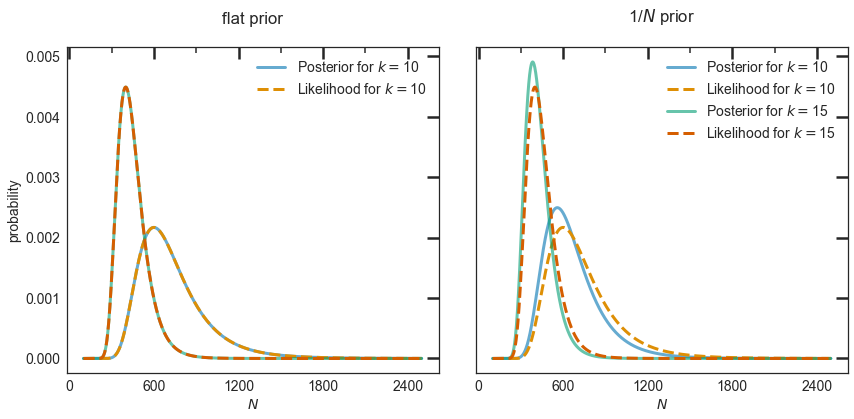

In [9]:
K, n, k_val = 100, 60, [10, 15] 

fig, axes = plt.subplots(1,2,figsize = (14,6), sharey= 'row')
ax1, ax2 = axes

# dictionary for the "maximum likelihood" estimates of N
N_estimates_hyperbolic_prior = {}

for ik, k in enumerate(k_val):
    
    ''' FLAT PRIOR '''
    # computing the likelihood values for the current k and each N in Nrange
    likelihood_values = likelihood(Nrange, K, k, n)
    
    # integrating the likelihood to normalize it afterwards
    integrated_likelihood = np.trapz(likelihood_values, Nrange)
    
    # compuring the posterior values for the current k and each N in Nrange assuming a FLAT prior on N
    posterior_flat = posterior(Nrange, K, k, n, flat_prior)
    
    # integrating the posterior to normalize it afterwards
    integrated_posterior_flat = np.trapz(posterior_flat, Nrange)
    
    # plotting the normalized posterior
    ax1.plot(Nrange, posterior_flat / integrated_posterior_flat, 
             lw = 3.0, alpha = 0.6, label = 'Posterior for $k = $%s'%k)
    
    # plotting the normalized likelihood
    ax1.plot(Nrange, likelihood_values / integrated_likelihood,
             lw = 3.0, ls = '--', label = 'Likelihood for $k = $%s'%k)
    
    
    '''HYPERBOLIC PRIOR'''
    # likelihoods stay the same since they do not depend on the prior
    posterior_hyperbolic = posterior(Nrange, K, k, n, hyperbolic_prior)
    integrated_posterior_hyperbolic = np.trapz(posterior_hyperbolic, Nrange)
    
    # plotting the normalized posterior
    ax2.plot(Nrange, posterior_hyperbolic / integrated_posterior_hyperbolic,
             lw = 3.0,alpha = 0.6,label = 'Posterior for $k = $%s'%k)
    
    # plotting the normalized likelihood
    ax2.plot(Nrange,likelihood_values / integrated_likelihood, 
             lw = 3.0, ls = '--', label = 'Likelihood for $k = $%s'%k)
    
    '''The "maximum likelihood" estimates of N'''
    # storing the estimates of N that maximize the likelihood and the posterior
    N_estimates_hyperbolic_prior[k] = {'Likelihood':Nrange[np.argmax(likelihood_values)],
                                       'Posterior':Nrange[np.argmax(posterior_hyperbolic)]}
    
    
    put_ticks(fig,axes[ik])
    axes[ik].set_xlabel('$N$')
    axes[ik].legend(loc = 'upper right')
    axes[ik].ticklabel_format(axis='x', style='plain')
    axes[ik].xaxis.set_major_locator(ticker.MultipleLocator(600))
    axes[ik].xaxis.set_minor_locator(ticker.MultipleLocator(300))

ax1.set_title('flat prior\n')
ax2.set_title(r'1/$N$ prior'+'\n')
ax1.set_ylabel('probability')
fig.subplots_adjust(wspace=0.1)

**What N is most likely?**

We found that with the flat prior, the likelihood is the same as the posterior (pretty much by definition). 

With the hyperbolic prior, the posterior is shifted to the left with respect to the likelihood, as our prior knowledge tells us that smaller values of $N$ are more likely.

Let's display our "most likely $N$" estimates for the two $k$ settings (10 and 15) we tested.

In [10]:
N_estimates_hyperbolic_prior

{10: {'Likelihood': 599, 'Posterior': 559},
 15: {'Likelihood': 399, 'Posterior': 384}}

#### Gaussian prior
Now, we will change the form of our prior to gaussian. By doing so, we believe that the population of fish in the lake is roughly some value **N0** but has a $1\sigma$ uncertainty of **sigma**.

In [11]:
def gaussian_prior(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-0.5 * (x - mu)**2 / sigma**2)

What is $\sigma$ in our case? We have two measurements — total volume of the lake, $V_{\mathrm{tot}} \pm \sigma_{V_{\mathrm{tot}}}$, as well as the volume one fish prefers to have for itself, $V_{\mathrm{fish}} \pm \sigma_{V_{\mathrm{fish}}}$. 

**Determining the uncertainty analytically**

The total number of fish is then roughly
<center> $N  = \frac{V_{\mathrm{tot}}}{V_{\mathrm{fish}}}$, </center>

with the uncertainty

<center> $\sigma_N  = \sqrt {\left( \frac{\sigma_{V_{\mathrm{tot}}}}   {V_{\mathrm{fish}}} \right)^2 + 
\left( \frac{ V_{\mathrm{tot}} \sigma_{V_{\mathrm{fish}}}}   {V_{\mathrm{fish}}^2} \right)^2} $ </center>



Putting this in a function:

In [12]:
v_tot, sig_tot, v_fish, sig_fish = 5000, 300, 10, 1

import sympy as sp
from sympy.abc import t, f

Nvalue = v_tot / v_fish
Nsig = aas.error_prop((t/f),[t, f],[v_tot, v_fish],[sig_tot, sig_fish], verbose  = False)
print('N =', Nvalue, 'pm', Nsig)

N = 500.0 pm 58.309518948453004


**Determining the uncertainty with Monte Carlo simulation**

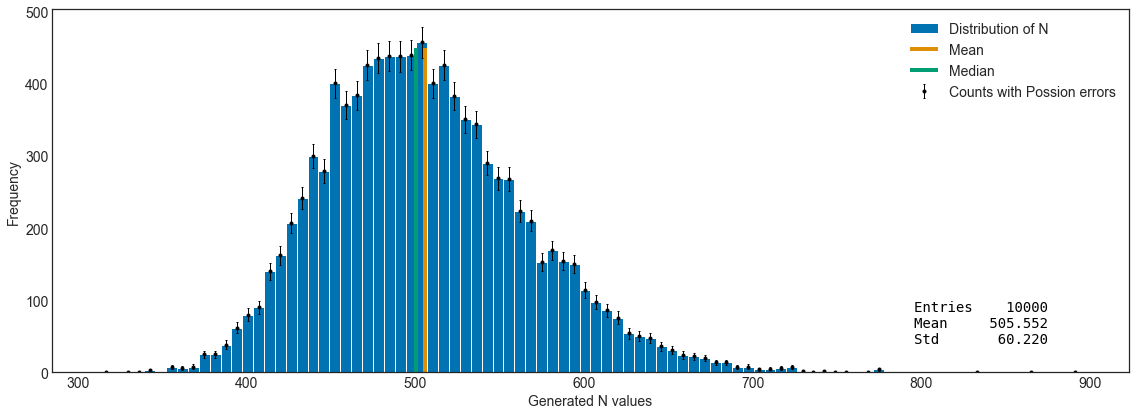

In [13]:
N_total = 10000
N_bins = 90

v_tot_gen = np.random.normal(v_tot, sig_tot, N_total)
v_fish_gen = np.random.normal(v_fish, sig_fish, N_total)
N_gen = v_tot_gen / v_fish_gen
    
Nmin, Nmax = min(N_gen), max(N_gen)
    
fig, ax = plt.subplots(figsize=(16,6))
aas.plot_hist(N_gen, Nmin, Nmax, N_bins, ax, xlabel='Generated N values', histlabel='Distribution of N', color=color[0])
ax.vlines(np.mean(N_gen), 0, 450, lw=4, color=color[1], label='Mean')
ax.vlines(np.median(N_gen), 0, 450, lw=4, color=color[2], label='Median')
ax.legend()
fig.tight_layout()

This time $K = 50$, $n = 30$, and $k = 4$ and we use a Gaussian prior.

The probability of having a value >= 409 when k = 4 is 0.697 according to the likelihood
The probability of having a value >= 409 when k = 8 is 0.045 according to the likelihood


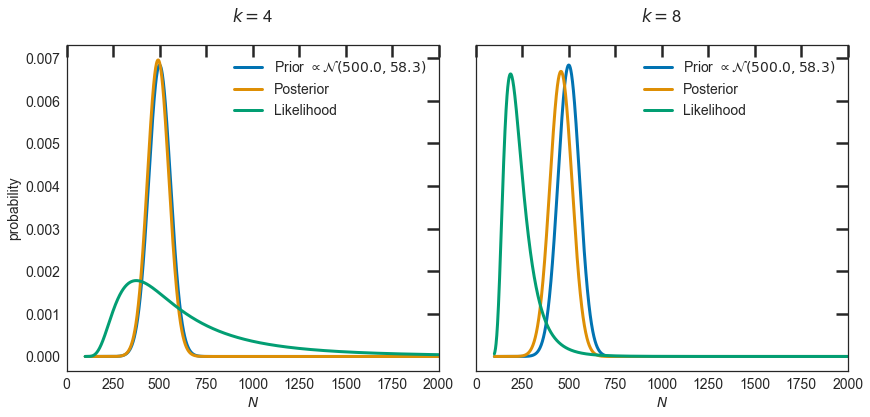

In [15]:
K, n, k_val = 50, 30, [4, 8]

fig, axes = plt.subplots(1,2,figsize = (14,6), sharey= 'row')
ax1, ax2 = axes

# dictionary for the "maximum likelihood" estimates of N
N_estimates_gaussian_prior = {}

# prior does not depend on k, so can be calculated outside the loop
gauss_prior_values = gaussian_prior(Nrange, Nvalue, Nsig)
integrated_prior = np.trapz(gauss_prior_values,Nrange)

for ik, k in enumerate(k_val):
    
    ''' GAUSSIAN PRIOR '''
    # computing the likelihood values for the current k and each N in Nrange
    likelihood_values = likelihood(Nrange, K, k, n)
    
    # integrating the likelihood to normalize it afterwards
    integrated_likelihood = np.trapz(likelihood_values, Nrange)
    
    # compuring the posterior values for the current k and each N in Nrange 
    # (settings of the gaussian can be tweaked here)
    posterior_values = posterior(Nrange, K, k, n, prior = lambda N: gaussian_prior(N, Nvalue, Nsig))
    
    # integrating the posterior to normalize it afterwards
    integrated_posterior = np.trapz(posterior_values, Nrange)
    
    #Plotting the normalized posterior as a function of N
    axes[ik].plot(Nrange, gauss_prior_values / integrated_prior, lw = 3.0, 
                  label = r'Prior $\propto \mathcal{N}(%s,%s)$'%(np.round(Nvalue,1), np.round(Nsig,1)))
    
    axes[ik].plot(Nrange, posterior_values / integrated_posterior, lw = 3.0,
                 label = 'Posterior')
    
    axes[ik].plot(Nrange, likelihood_values / integrated_likelihood, lw = 3.0,
                 label = 'Likelihood')
    
    put_ticks(fig,axes[ik])
    
    axes[ik].set_xlabel('$N$')
    axes[ik].set_title('$k = $%s'%k+'\n')
    
    axes[ik].set_xlim(0,2000)
    axes[ik].ticklabel_format(axis='x',style='plain')
    
    axes[ik].legend(loc = 'upper right')
    
    '''The "maximum likelihood" estimates of N'''
    # storing the estimates of N that maximize the likelihood and the posterior
    N_estimates_gaussian_prior[k] = {'Likelihood':Nrange[np.argmax(likelihood_values)],
                                       'Posterior':Nrange[np.argmax(posterior_values)]}
    
    '''How likely is it to have a value >= 409'''
    # normalize likelihood
    likelihood_normalized = likelihood_values / integrated_likelihood

    # calculate integral
    prob = np.trapz(likelihood_normalized[np.where(Nrange == 409)[0][0]:], Nrange[np.where(Nrange == 409)[0][0]:])
    
    print(f'The probability of having a value >= 409 when k = {k} is', round(prob,3), 'according to the likelihood')
    
    
    
#for ax in axes:
#    ax.set_xlabel('$N$')
#    put_ticks(fig,ax)
#    ax.legend(loc = 'upper right')
#    ax.ticklabel_format(axis='x', style='plain')
#    ax.xaxis.set_major_locator(ticker.MultipleLocator(600))
#    ax.xaxis.set_minor_locator(ticker.MultipleLocator(300))



axes[0].set_ylabel('probability')

fig.subplots_adjust(wspace=0.1)

In [16]:
N_estimates_gaussian_prior

{4: {'Likelihood': 374, 'Posterior': 492},
 8: {'Likelihood': 187, 'Posterior': 458}}

**According to the likelihood PDF, how likely is it to have a value ≥ 409?**

(hint integrate the tail of the likelihood distribution ≥ 409)

The probability of having a value >= 409 when k = 4 is 0.697 according to the likelihood even though the most likely N according to the posterior is 492.

The probability of having a value >= 409 when k = 8 is 0.045 according to the likelihood even though the most likely N according to the posterior is 458.

With such a divergence between the likelihood, posterior, and dependence on the prior, it is worth investigating
whether the prior — or its parameters — or the likelihood are appropriate.

**Smart trick to get counter in loop**

In [17]:
values = ['a', 'b', 'c', 'd', 'e']

for count, value in enumerate(values):
    print(count, value)

0 a
1 b
2 c
3 d
4 e


# Interpolation and splines

Splines: Function that interpolates a set of data points and guarantees smoothness at the data points.

Linear splines (straight lines). Might miss features. 

Cubic splines (curvy lines). Matches the first and/or second order derivatives. Might invent features. The more substantial the change (magnitude of the second derivates) the more likely a cubic spline will be problematic and over/undershoot.

Why don't we have quadratic splines? Because the parabola can't curve both ways.

For n data points, an prrox n-order polynomial will go through all the data points smoothly. Often the interpolation behavior near the edges are problematic.

Ringing: when you go from somthing changing to flat. Then the line tends to curve on the flat area. 

### Exercise 1

In [24]:
data_dust = np.genfromtxt('DustLog_forClass.txt')
depth = data_dust[:,0]
logdust = data_dust[:,1]

f_lin = interpolate.interp1d(depth, logdust)
f_cub = interpolate.interp1d(depth, logdust, kind = 'cubic')

In [25]:
x = np.linspace(min(depth), max(depth), 100000)

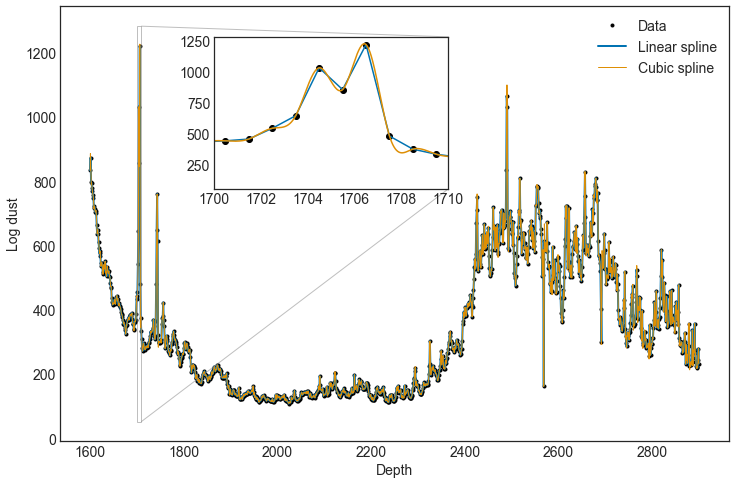

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(depth, logdust, '.', color='black', label = 'Data')
ax.plot(depth, f_lin(depth), label = 'Linear spline', lw=2)
ax.plot(x, f_cub(x), label = 'Cubic spline', lw=1)
ax.legend()
ax.set_xlabel('Depth')
ax.set_ylabel('Log dust')

# two first coordinates are x and y coordinate for the low left corner
# next two numbers are the width and the height
axins = ax.inset_axes([0.23, 0.58, 0.35, 0.35]) 
axins.plot(depth, logdust, 'o', color='black', label = 'Data')
axins.plot(depth, f_lin(depth), label = 'Linear spline')
axins.plot(x, f_cub(x), label = 'Cubic spline')
axins.set_xlim(1700,1710)
ax.indicate_inset_zoom(axins);

B-splines and smoothing.

If you want to smooth an odd-order spline with n data points use $s = n \pm \sqrt(2n)$

### Exercise 2

In [27]:
data_cubic = np.genfromtxt('SplineCubic.txt')
x = data_cubic[:,0]
y = data_cubic[:,1]

xaxis = np.linspace(min(x), max(x), 100000)

f_lin = interpolate.interp1d(x, y)
f_qua = interpolate.interp1d(x, y, kind = 'quadratic')
f_cub = interpolate.interp1d(x, y, kind = 'cubic')

# alternatives
f_cub_pchip = interpolate.pchip_interpolate(x, y, xaxis)

weights = np.ones(len(x))
weights[3:6] = np.ones(3)*5

f_lin2 = interpolate.splrep(x, y, s=100, k=1)
f_qua2 = interpolate.splrep(x, y, s=100, k=2)
f_cub2 = interpolate.splrep(x, y, s=600, w= weights, k=3)

f_lin_bspline = interpolate.BSpline(*f_lin2)(xaxis)
f_qua_bspline = interpolate.BSpline(*f_qua2)(xaxis)
f_cub_bspline = interpolate.BSpline(*f_cub2)(xaxis)

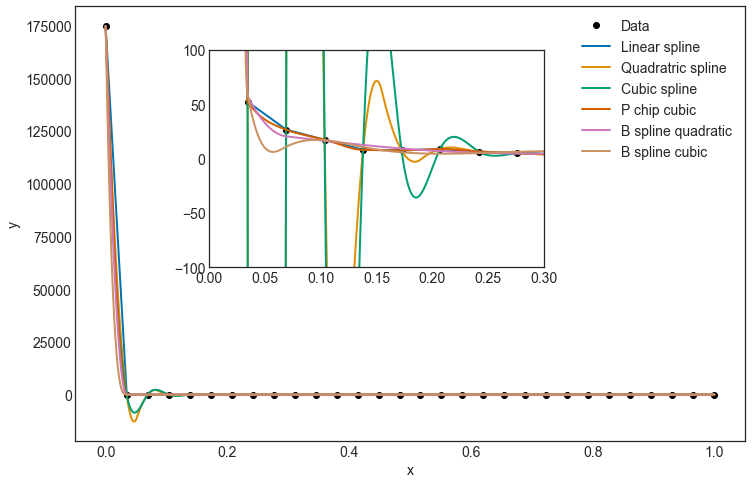

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,y,'o', label = 'Data', color='black')
ax.plot(xaxis, f_lin(xaxis), label = 'Linear spline', lw=2)
ax.plot(xaxis, f_qua(xaxis), label = 'Quadratric spline', lw=2)
ax.plot(xaxis, f_cub(xaxis), label = 'Cubic spline', lw=2)
ax.plot(xaxis, f_cub_pchip, label = 'P chip cubic', lw=2)
ax.plot(xaxis, f_qua_bspline, label = 'B spline quadratic', lw=2)
ax.plot(xaxis, f_cub_bspline, label = 'B spline cubic', lw=2)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

axins = ax.inset_axes([0.2, 0.4, 0.5, 0.5]) 
axins.plot(x, y, 'o', color='black', label = 'Data')
axins.plot(xaxis, f_lin(xaxis), label = 'Linear spline', lw=2)
axins.plot(xaxis, f_qua(xaxis), label = 'Quadratric spline', lw=2)
axins.plot(xaxis, f_cub(xaxis), label = 'Cubic spline', lw=2)
axins.plot(xaxis, f_cub_pchip, label = 'P chip cubic', lw=2)
axins.plot(xaxis, f_qua_bspline, label = 'B spline qua', lw=2)
axins.plot(xaxis, f_cub_bspline, label = 'B spline cubic', lw=2)
axins.set_xlim(0,0.3)
axins.set_ylim(-100,100);
#ax.indicate_inset_zoom(axins);

In [30]:
from scipy import integrate

In [32]:
lowlim, highlim = 1e-5, 1e-2

int_lin = integrate.quad(f_lin, lowlim, highlim)
int_qua = integrate.quad(f_qua, lowlim, highlim)
int_cub = integrate.quad(f_cub, lowlim, highlim)
int_pchip = np.trapz(f_cub2, np.linspace(lowlim, highlim, len(f_cub2)))

print('Value of integral from x = 1e-5 to x = 1e-2 for \
       \nLinear', int_lin[0], '\nQuadratic', int_qua[0], '\nCubic', int_cub[0], '\nCubic pchip', int_pchip)

Value of integral from x = 1e-5 to x = 1e-2 for        
Linear 1493.3982827723833 
Quadratic 1373.8929579683593 
Cubic 1313.2548778155267 
Cubic pchip [ 8.73146135e+02  1.34857101e+00 -7.92063595e-02  1.42029267e-01
  5.35094590e-03  6.41771882e-02 -1.79532641e-02  3.75208357e-02
  1.22939743e-02  9.99000000e-03  9.99000000e-03  9.99000000e-03
  9.99000000e-03]


In [33]:
lowlim, highlim = 0.03, 0.1

int_lin = integrate.quad(f_lin, lowlim, highlim)
int_qua = integrate.quad(f_qua, lowlim, highlim)
int_cub = integrate.quad(f_cub, lowlim, highlim)
#int_pchip = np.trapz(f_cub_pchip, np.linspace(lowlim, highlim, len(f_cub2)))

print('Value of integral from x = 1e-5 to x = 1e-2 for \
       \nLinear', int_lin[0], '\nQuadratic', int_qua[0], '\nCubic', int_cub[0], '\nCubic pchip', int_pchip)

Value of integral from x = 1e-5 to x = 1e-2 for        
Linear 53.42664904677584 
Quadratic -176.23780365380253 
Cubic -115.92359623900555 
Cubic pchip [ 8.73146135e+02  1.34857101e+00 -7.92063595e-02  1.42029267e-01
  5.35094590e-03  6.41771882e-02 -1.79532641e-02  3.75208357e-02
  1.22939743e-02  9.99000000e-03  9.99000000e-03  9.99000000e-03
  9.99000000e-03]


The integral should NEVER be negative. What does a negative pdf mean ?? Does not make sense. The best one is Cubic pchip!

### Exercise 3

In [34]:
data_Osc = np.genfromtxt('SplineOsc1.txt')
x = data_Osc[:,0]
y = data_Osc[:,1]

xaxis = np.linspace(min(x), max(x), 100000)
f_cub_pchip = interpolate.pchip_interpolate(x, y, xaxis)

weights = np.ones(len(x))
weights[200:1800] *= 0.1 
weights[0:200] *= 0.001

f_cub2 = interpolate.splrep(x, y, s=2.6, w = weights, k=3)
f_cub_bspline = interpolate.BSpline(*f_cub2)(xaxis)

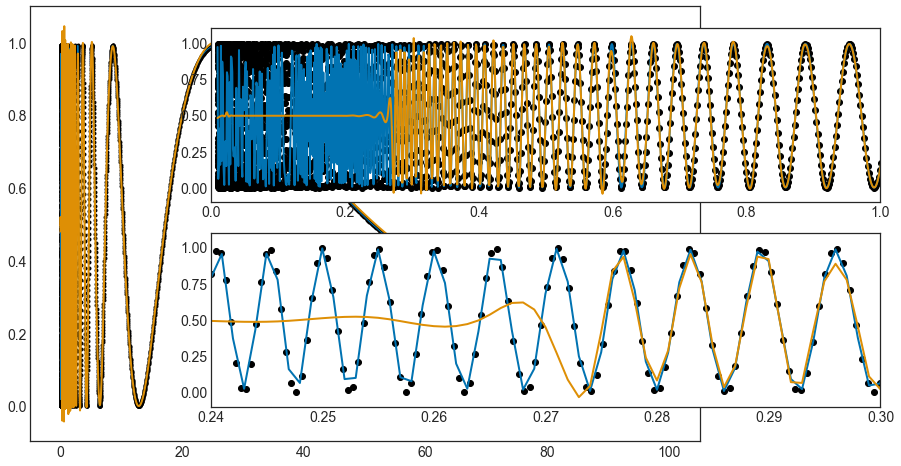

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,y,'.', label = 'Data', color='black')
ax.plot(xaxis[::10], f_cub_pchip[::10], label = 'P chip cubic', lw=1)
ax.plot(xaxis, f_cub_bspline, label = 'B spline cubic', lw=2)

axins = ax.inset_axes([0.27, 0.55, 1, 0.4]) 
axins.plot(x, y, 'o', color='black', label = 'Data')
axins.plot(xaxis, f_cub_pchip, label = 'P chip cubic', lw=2)
axins.plot(xaxis, f_cub_bspline, label = 'B spline cubic', lw=2)
axins.set_xlim(0,1)
axins.set_ylim(-0.1,1.1)

axins2 = ax.inset_axes([0.27, 0.08, 1, 0.4]) 
axins2.plot(x, y, 'o', color='black', label = 'Data')
axins2.plot(xaxis, f_cub_pchip, label = 'P chip cubic', lw=2)
axins2.plot(xaxis, f_cub_bspline, label = 'B spline cubic', lw=2)
axins2.set_xlim(0.24,0.3)
axins2.set_ylim(-0.1,1.1);